# Ford GoBike Analysis

![Intro](https://live.staticflickr.com/4330/35583431090_0a194220ba_b.jpg)

### By Mehrnaz Siavoshi

## Investigation Overview

In this investigation, I will be performing descriptive analysis on all Ford GoBike / BayWheels trip data for 2019. This is a bike rental service that allows riders to pay for their bike rental on a per-minute basis and is a popular transportation choice in San Fransisco. 

Here, I will look at the date and time of trips, their duration, subscriber status, and more. 

## Dataset Overview

Data was obtained from the BayWheels website. A CSV file for each month was downloaded and combined into a master dataframe. The final, cleaned dataset contains 2,506,983 trip observations with 22 features (some data is repeated, for example there is both a timestamp column and day/month columns). The dataset has no missing data or other systemic issues. 

In [2]:
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import calendar
import time

%matplotlib inline

# Suppress warnings for ease of viewing
import warnings
warnings.simplefilter("ignore")

# Import cleaned dataset. This dataset combines all 12 months of data, makes some
# formatting changes, and adds in new month and day columns. 
# For cleaning process details, see exploration.ipynb

bike_data_master = pd.read_csv("bike_data_master.csv")

# To check for proper import, the following line should output (2506983, 23)
# bike_data_master.shape

## Univariate Exploration 

Univariate exploration involves looking at trends in one variable at a time. In this section, the following will be explored:

- Trips by month.
- Top 10 starting stations.
- Starting station geographic density.
- Trips by length. 
- Trips by day of the week. 
- Trips by time of day. 
- Bike ID. 

### Trips by Month

We see that July, March, October, and April have the highest usage. This is slightly unexpected because tourism typically spikes in summer, but June and August have relatively low usage. Additionally, there are more rainy days in spring (March/April). 

Text(0, 0.5, 'Trip Count')

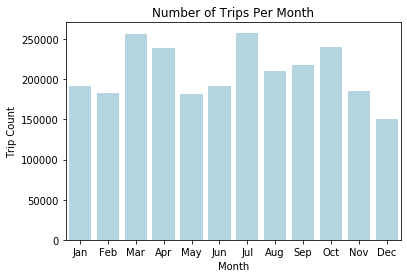

In [4]:
sb.countplot(data=bike_data_master, x='month', color='lightblue')
plt.title("Number of Trips Per Month")
plt.xlabel("Month")
plt.ylabel("Trip Count")

### Top 10 Starting Stations

These are the top 10 busiest stations. We see that the most active stations had well over 30,000 riders in all of 2019. 

Text(0.5, 0, 'Trip Count')

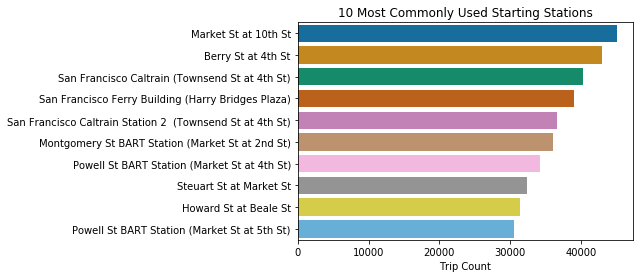

In [5]:
stations = bike_data_master.start_station_name.value_counts().nlargest(10)

sb.barplot(y=stations.index, x=stations, palette="colorblind")
plt.title("10 Most Commonly Used Starting Stations")
plt.xlabel("Trip Count")


### Station Geographic Density Within San Fransisco

From the map, we clearly see a high density of stations in the downtown San Fransisco area where both the population is higher, and there are likely to be more tourists.

In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

geography = bike_data_master

geography = geography[geography.start_station_latitude.between(37.58, 37.86)]
geography = geography[geography.start_station_longitude.between(-122.55, -122.34)]

geography['geometry'] = geography.apply(lambda row: Point(row['start_station_longitude'], row['start_station_latitude']), axis=1)
geography.head()

geo_data = gpd.GeoDataFrame(geography, geometry='geometry')

sf = gpd.read_file('sf_map.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

KeyboardInterrupt: 

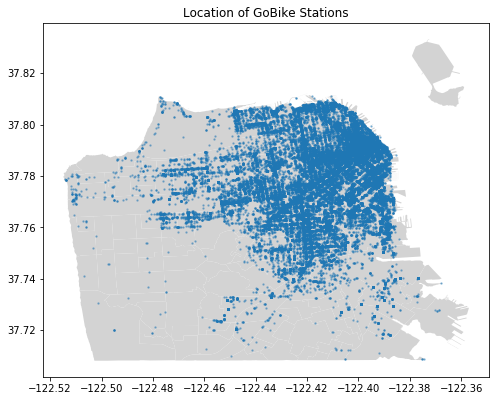

In [34]:
fig, ax = plt.subplots(1, figsize = (8,8))
sf_map = sf['geometry'].plot(ax=ax, color = 'lightgray')
geo_data.plot(ax=sf_map, marker = 'o', markersize = 2, alpha = 0.4)
plt.title("Location of GoBike Stations")
plt.show()

### Trips by Length

Simply doing a log scale histogram is not very informative as it looks like many rentals are well over a day long. Trips under 3 hours and under 1 hour are graphed separately. With all three histograms taken together, we see that the vast majority of trips are under 20 minutes long. 

Text(0, 0.5, 'Log of Count')

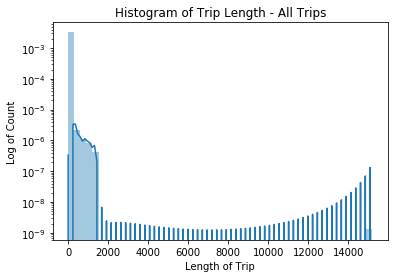

In [7]:
ax = sb.distplot(bike_data_master.minutes)
ax.set_yscale('log')
plt.title("Histogram of Trip Length - All Trips")
plt.xlabel("Length of Trip")
plt.ylabel("Log of Count")

Text(0, 0.5, 'Log of Count')

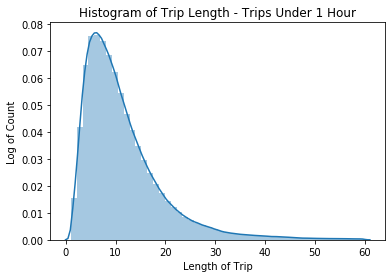

In [8]:
short_trip = bike_data_master[bike_data_master.minutes.between(0, 60)]
ax = sb.distplot(short_trip.minutes)
plt.title("Histogram of Trip Length - Trips Under 1 Hour")
plt.xlabel("Length of Trip")
plt.ylabel("Log of Count")

### Trips by Day of the Week

Interestingly, we see that most trips occur during the week instead of on weekends. This suggests that most trips are for work commutes instead of for leisure. This correlates with previous data showing that trips do not increase significantly over summer, which would be expected if most riders were tourists.  

Text(0, 0.5, 'Trip Count')

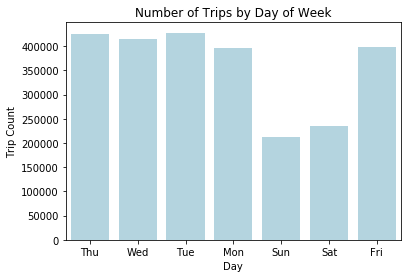

In [9]:
sb.countplot(data=bike_data_master, x='day', color='lightblue')

plt.title("Number of Trips by Day of Week")
plt.xlabel("Day")
plt.ylabel("Trip Count")

### Trips by Time of Day

As expected, there are very few rides during the night. However, according to the bimodal graph, the vast majority of trips occur around 8-9 am and around 5-6 pm. This also correlates with previous findings that most rides are likely commutes as these are typical commute times.

Text(0, 0.5, 'Trip Count')

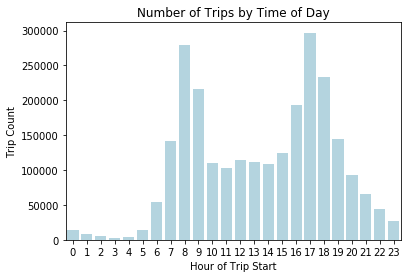

In [10]:
sb.countplot(data=bike_data_master, x='hour', color='lightblue')

plt.title("Number of Trips by Time of Day")
plt.xlabel("Hour of Trip Start")
plt.ylabel("Trip Count")

### Bike ID Analysis

As an interesting fact, we can also see which bikes are used most often. From the bar graph, we can see that some bikes are used much more frequently than others. From value_counts, we can see that 11,070 bikes were used in 2019. 

There were 153 high-use bikes (used, on average, more than twice a day). 

(-0.5, 11069.5, 0.0, 957.6)

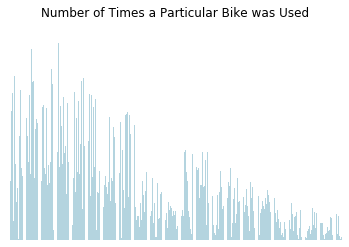

In [11]:
sb.countplot(data=bike_data_master, x='bike_id', color='lightblue')

plt.title("Number of Times a Particular Bike was Used")
plt.xlabel("Bike ID")
plt.ylabel("Trip Count")
plt.axis('off')

## Bivariate Exploration

Bivariate explorations look at whether two variables are correlated. In this section, the following will be explored:

- The day of week and trip duration. 
- The day of the week and trip start time. 
- The trip duration and subscriber status. 


**Note:** For all analyses that use trip time, the short_trip dataset will be used. This dataset only contains trips 60 minutes or shorter, which encompasses the vast majority of trips without including the effect of significant outliers. 

### Average Trip Duration by Day of the Week

Interestingly, while there are more rides during the week, rides are typically longer on weekends. This hints that weekend rides tend to be for lesiure. 

Text(0, 0.5, 'Average Trip Length')

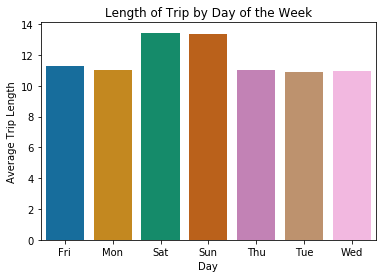

In [12]:
trip_per_day = short_trip.groupby(['day']).mean()
sb.barplot(x=trip_per_day.index, y=trip_per_day.minutes, palette = 'colorblind')

plt.title("Length of Trip by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Average Trip Length")

### Day of Week and Trip Start Time

We see that, on average, most trips are in the afternoon with Saturday and Sunday having more afternoon trips.

Text(0, 0.5, 'Mean Start Time')

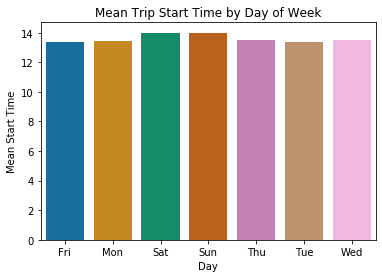

In [13]:
day_av_time = bike_data_master.groupby('day').mean()
sb.barplot(x=day_av_time.index, y=day_av_time.hour, palette='colorblind')

plt.title("Mean Trip Start Time by Day of Week")
plt.xlabel("Day")
plt.ylabel("Mean Start Time")

### Trips Duration and Subscriber Status

We see that customers tend to have longer trips (over twice as long) than subscribers. This perhaps hints that customers (typically single users) tend to ride for lesiure or tourism and, therefore, will have longer trips. 

Text(0, 0.5, 'Mean Trip Duration')

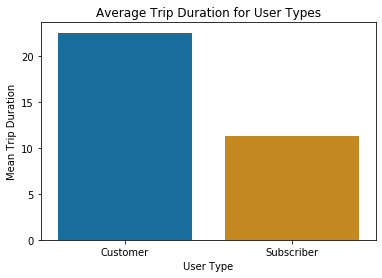

In [14]:
sub_type = bike_data_master.groupby('user_type').mean()
sb.barplot(x=sub_type.index, y=sub_type.minutes, palette='colorblind')

plt.title("Average Trip Duration for User Types")
plt.xlabel("User Type")
plt.ylabel("Mean Trip Duration")

## Multivariate Exploration

Multivariate exploration considers more than 2 variables to determine trends. In this section, the following will be explored:    

- Interaction between trip hour, day, month and length. 
- Trips by day of week and month.
- Trips by hour and day of the week. 
- Trips by day of week for different subscriber statuses.
- Interaction between trip hour and subscriber status. 

### Correlation between Trip Hour Day, Month, and Duration

There isn't much of a correlation between the time of the trip, the date of the trip, and its length. 

Text(0.5, 1, 'Correlation Analysis')

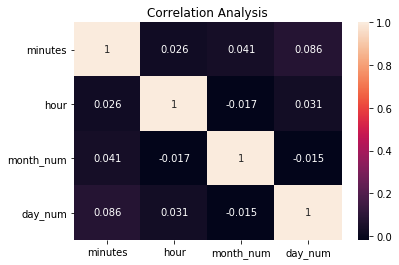

In [15]:
sb.heatmap(short_trip[['minutes', 'hour', 'month_num', 'day_num']].corr(), annot=True)

plt.title("Correlation Analysis")

### Trips Count by Day of Week and Month

Trends tend to match the aggregate data. Interestingly, rates fall midweek in December, probably because in 2019 Christmas fell on a wednesday. It is interesting, however, that midweek trips rose in July.

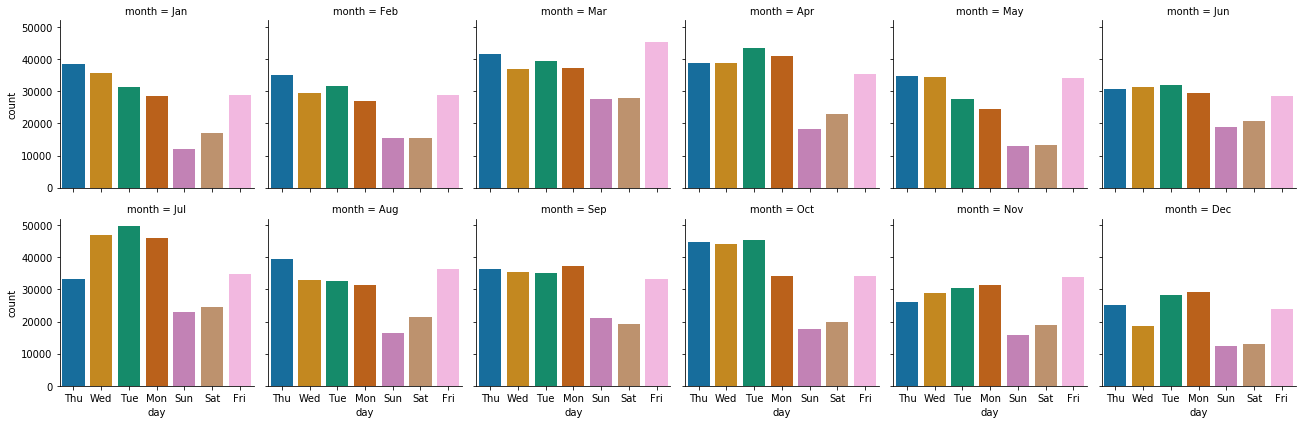

In [31]:
ax = sb.catplot(data=bike_data_master, x='day', col='month', kind='count', col_wrap=6, palette = 'colorblind', height=3)

### Trips by Hour and Day of Week

Workdays, as expected, have a bimodal graph. Weekends do not have this shape and have more of a normal shape with most rides occuring midday. Interestingly, Friday evening is not particularly different from other weekdays. 

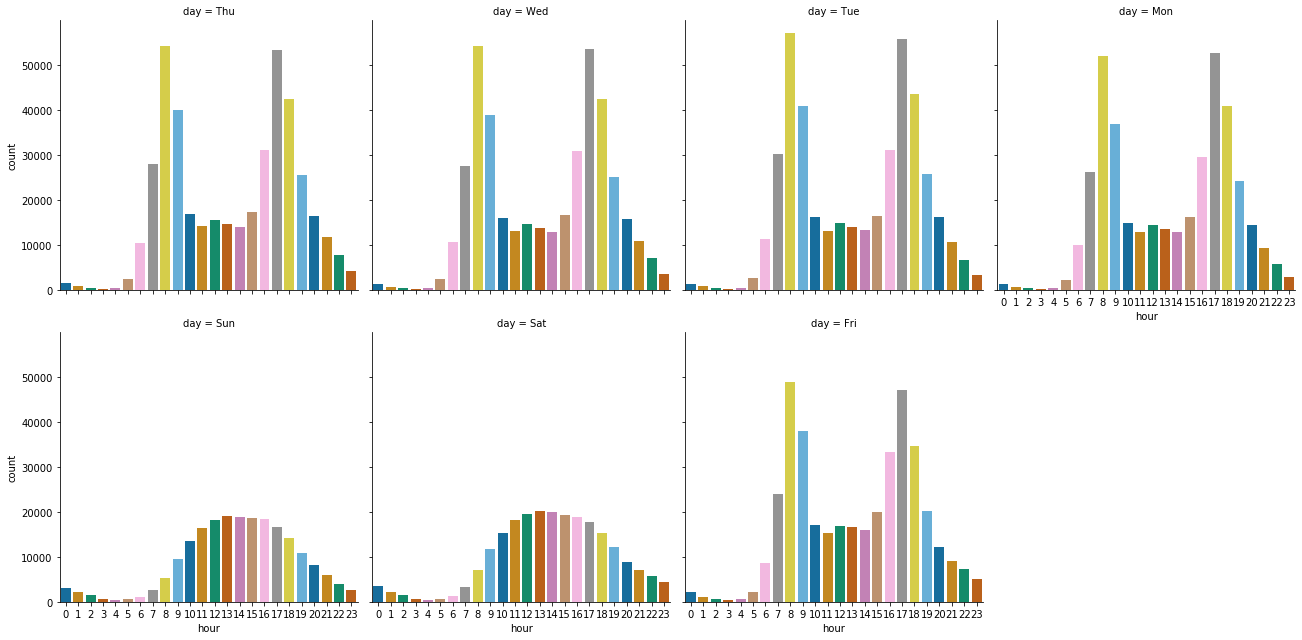

In [28]:
sb.catplot(data=bike_data_master, x='hour', col='day', kind='count', col_wrap=4, palette = 'colorblind', height=4.5)

### Trips by Day of Week by Subscriber Status

As expected, we see that subscribers tend to use bikes more during the week. Those who are subscribers will typically use the bikes for their commute. Customers, on the other hand, tend to be tourists and have a steady bike usage rate over the week.

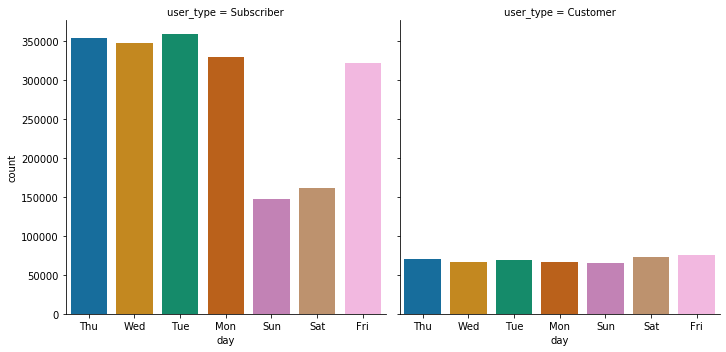

In [17]:
sb.catplot(data=bike_data_master, x='day', col='user_type', kind='count', palette='colorblind')

### Trips per Hour by Subscriber Status

In concordance with the previous plots, we see that typical usage from the aggregate data more closely matches with the subscribers who tend to have large usage spikes during commute times. Customers, who are typically tourists, have most of their usage in the afternoon. Interestingly, though, customers still have the bivariate shape with the same peaks as the subscribers. This indicates that, perhaps, some of the customers are occasional bike commuters or are trying the service for their commute before subscribing.

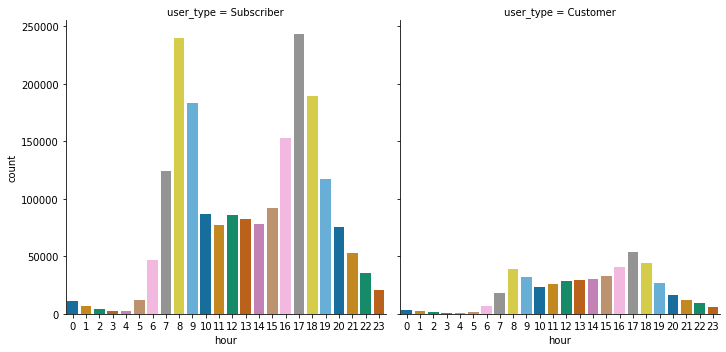

In [18]:
sb.catplot(data=bike_data_master, x='hour', col='user_type', kind='count', palette = 'colorblind')

# Conclusion

In this project, descriptive visualizations were created for the 2019 Ford GoBike/BayWheels dataset. Through the analysis, some interesting observations were made: 

- There is increased usage in March, April, July, and October.
- The vast majority of trips are less than 10 minute long. 
- Most of the bikes are used for commutes, as demonstrated by the peaks in usage around 8-9 AM and 5-6 PM.
    - Customers, who likely are not using the bikes for commutes, typically have longer rides. 
- The time of day when a bike is rented has no impact on how long the trip will be. 
    - However, any true effect of time of day may be hidden by the overwhelming number of trips less than 10 minutes in duration. 
- In the customer use by time of day graph, we see that some customers may be using the bikes for a one-off commute, or to test the service for a commute before becoming a subscriber.


In [32]:
# Export slides as html

! jupyter nbconvert slide_deck.ipynb --to slides --template output_toggle SlidesExporter.reveal_theme=sky
 

[NbConvertApp] WARNING | pattern 'SlidesExporter.reveal_theme=sky' matched no files
[NbConvertApp] Converting notebook slide_deck.ipynb to slides
[NbConvertApp] Writing 695398 bytes to slide_deck.slides.html
